In [111]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [112]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Mythical code button"></form>''')

In [113]:
import arrow
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
#plt.style.use('classic')
from matplotlib.patches import Rectangle
import pickle
from cmocean import cm
import warnings
import netCDF4 as nc
import sys
sys.path.append('../pyscripts/bylayer_extract/')
import extract_bylayer_mean_BOXMASK as ebmBOX 
from importlib import reload
from salishsea_tools import viz_tools

import sys
sys.path.append('/data/tjarniko/mocsy')
import mocsy

%matplotlib inline
warnings.simplefilter('ignore')

# plt.rcParams.update({'font.size': 13,
#                      'xtick.labelsize' : 13,
#                      'ytick.labelsize' : 13})

### egleston calculations

In [114]:

def calculate_Egleston_factors(ttemp, tsal, talk, tdic_A, dep, del_dic):

    tdic_B = tdic_A + del_dic
    
    tzero = np.zeros_like(tdic_A)
    
    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_A, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tinsitu', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_A,pco2_A,fco2,co2_A,hco3,co3,OmegaA_A,OmegaC,BetaD,DENis,p,Tis = response_tup

    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_B, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tinsitu', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_B,pco2_B,fco2,co2_B,hco3,co3,OmegaA_B,OmegaC,BetaD,DENis,p,Tis = response_tup

    omega_DIC = 1/((np.log(OmegaA_B)-np.log(OmegaA_A))/(del_dic))
    
    Hplus_A = 10**(-1*pH_A); Hplus_B = 10**(-1*pH_B)
    beta_DIC = 1/((np.log(Hplus_B)-np.log(Hplus_A))/(del_dic))
    
    gamma_DIC = 1/((np.log(co2_B)-np.log(co2_A))/(del_dic))
    
    
    
    return omega_DIC, beta_DIC, gamma_DIC, OmegaA_A, BetaD

# t_omega_DIC, t_beta_DIC, t_gammaDIC, t_OmegaA_A = \
# calculate_Egleston_factors\
# (tTEMP, tSAL, tALK*1e-3, tDIC*1e-3, tPRES, 0.01)



def calculate_Egleston_factors_tPOT(ttemp, tsal, talk, tdic_A, dep, del_dic):

    tdic_B = tdic_A + del_dic
    
    tzero = np.zeros_like(tdic_A)
    
    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_A, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tpot', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_A,pco2_A,fco2,co2_A,hco3,co3,OmegaA_A,OmegaC,BetaD,DENis,p,Tis = response_tup

    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_B, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tpot', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_B,pco2_B,fco2,co2_B,hco3,co3,OmegaA_B,OmegaC,BetaD,DENis,p,Tis = response_tup

    omega_DIC = 1/((np.log(OmegaA_B)-np.log(OmegaA_A))/(del_dic))
    
    Hplus_A = 10**(-1*pH_A); Hplus_B = 10**(-1*pH_B)
    beta_DIC = 1/((np.log(Hplus_B)-np.log(Hplus_A))/(del_dic))
    
    gamma_DIC = 1/((np.log(co2_B)-np.log(co2_A))/(del_dic))
    
    return omega_DIC, beta_DIC, gamma_DIC, OmegaA_A, BetaD



## calculating BR3 oma, oma_dic and pickling

# convert salinity from g/kg, make sure to use potential temperature T option and convert cons T to pot T

In [115]:
import gsw

tdir = '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/PI_CARBON_PAPER/MAIN_ANALYSIS/pkls/'
BR3_dic_s = np.ravel(pickle.load(open(tdir+'BR3_DIC_summer_mean.pkl', 'rb')))
BR3_dic_s[BR3_dic_s == 0] = np.nan
BR3_dic_s[BR3_dic_s > 1e5] = np.nan

BR3_ta_s = np.ravel(pickle.load(open(tdir+'BR3_TA_summer_mean.pkl', 'rb')))
BR3_ta_s[BR3_ta_s> 1e5] = np.nan
BR3_ta_s[BR3_dic_s == 0] = np.nan

BR3_temp_s2 = np.ravel(pickle.load(open(tdir+'BR3_temp_summer_mean.pkl', 'rb')))
BR3_temp_s2[BR3_temp_s2> 1e5] = np.nan
BR3_temp_s2[BR3_dic_s == 0] = np.nan

BR3_sal_s2 = np.ravel(pickle.load(open(tdir+'BR3_sal_summer_mean.pkl', 'rb')))
BR3_sal_s2[BR3_sal_s2> 1e5] = np.nan
BR3_sal_s2[BR3_dic_s == 0] = np.nan

BR3_temp_s = gsw.pt_from_CT(BR3_sal_s2,BR3_temp_s2)
BR3_sal_s= BR3_sal_s2*35/35.16504


tdir = '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/PI_CARBON_PAPER/MAIN_ANALYSIS/pkls/'
BR3_dic_w = np.ravel(pickle.load(open(tdir+'BR3_DIC_winter_mean.pkl', 'rb')))
BR3_dic_w[BR3_dic_w == 0] = np.nan
BR3_dic_w[BR3_dic_w > 1e5] = np.nan

BR3_ta_w = np.ravel(pickle.load(open(tdir+'BR3_TA_winter_mean.pkl', 'rb')))
BR3_ta_w[BR3_ta_w> 1e5] = np.nan
BR3_ta_w[BR3_dic_w == 0] = np.nan

BR3_temp_w2 = np.ravel(pickle.load(open(tdir+'BR3_temp_winter_mean.pkl', 'rb')))
BR3_temp_w2[BR3_temp_w2> 1e5] = np.nan
BR3_temp_w2[BR3_dic_w == 0] = np.nan

BR3_sal_w2 = np.ravel(pickle.load(open(tdir+'BR3_sal_winter_mean.pkl', 'rb')))
BR3_sal_w2[BR3_sal_w2> 1e5] = np.nan
BR3_sal_w2[BR3_dic_w == 0] = np.nan

BR3_temp_w = gsw.pt_from_CT(BR3_sal_w2,BR3_temp_w2)
BR3_sal_w= BR3_sal_w2*35/35.16504

print('ready to calculate Egleston')
w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
dep = np.ravel((w['gdept_0'][0,:,:,:]))


#clculate rev fact
# BR3_sss_omega_dic, BR3_sss_beta_dic, BR3_sss_gamma_dic, BR3_sss_OmegaA_A, BR3_sss_BetaD = \
# calculate_Egleston_factors_tPOT\
# (BR3_temp_s, BR3_sal_s, BR3_ta_s*1e-3, BR3_dic_s*1e-3, dep, 0.01)

# BR3_ssw_omega_dic, BR3_ssw_beta_dic, BR3_ssw_gamma_dic, BR3_ssw_OmegaA_A, BR3_ssw_BetaD = \
# calculate_Egleston_factors_tPOT\
# (BR3_temp_w, BR3_sal_w, BR3_ta_w*1e-3, BR3_dic_w*1e-3, dep, 0.01)

# BR3_sss_omega_dic = BR3_sss_omega_dic.reshape(40,898,398)
# pickle.dump(BR3_sss_omega_dic, open("../pkls/BR3_omega_dic_summer_mean.pkl", 'wb'))
# BR3_ssw_omega_dic = BR3_ssw_omega_dic.reshape(40,898,398)
# pickle.dump(BR3_ssw_omega_dic, open("../pkls/BR3_omega_dic_winter_mean.pkl", 'wb'))

# BR3_sss_gamma_dic = BR3_sss_gamma_dic.reshape(40,898,398)
# pickle.dump(BR3_sss_gamma_dic, open("../pkls/BR3_gamma_DIC_summer_mean.pkl", 'wb'))
# BR3_ssw_gamma_dic = BR3_ssw_gamma_dic.reshape(40,898,398)
# pickle.dump(BR3_ssw_gamma_dic, open("../pkls/BR3_gamma_DIC_winter_mean.pkl", 'wb'))

# BR3_sss_BetaD = BR3_sss_BetaD.reshape(40,898,398)
# pickle.dump(BR3_sss_BetaD, open("../pkls/BR3_BetaD_summer_mean.pkl", 'wb'))
# BR3_ssw_BetaD = BR3_ssw_BetaD.reshape(40,898,398)
# pickle.dump(BR3_ssw_BetaD, open("../pkls/BR3_BetaD_winter_mean.pkl", 'wb'))

print('done and pickled')

ready to calculate Egleston
done and pickled


    ## same for PI8

In [116]:
import gsw

tdir = '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/PI_CARBON_PAPER/MAIN_ANALYSIS/pkls/'
PI9_dic_s = np.ravel(pickle.load(open(tdir+'PI9_DIC_summer_mean.pkl', 'rb')))
PI9_dic_s[PI9_dic_s == 0] = np.nan
PI9_dic_s[PI9_dic_s > 1e5] = np.nan

PI9_ta_s = np.ravel(pickle.load(open(tdir+'PI9_TA_summer_mean.pkl', 'rb')))
PI9_ta_s[PI9_ta_s> 1e5] = np.nan
PI9_ta_s[PI9_dic_s == 0] = np.nan

PI9_temp_s2 = np.ravel(pickle.load(open(tdir+'PI9_temp_summer_mean.pkl', 'rb')))
PI9_temp_s2[PI9_temp_s2> 1e5] = np.nan
PI9_temp_s2[PI9_dic_s == 0] = np.nan

PI9_sal_s2 = np.ravel(pickle.load(open(tdir+'PI9_sal_summer_mean.pkl', 'rb')))
PI9_sal_s2[PI9_sal_s2> 1e5] = np.nan
PI9_sal_s2[PI9_dic_s == 0] = np.nan

PI9_temp_s = gsw.pt_from_CT(PI9_sal_s2,PI9_temp_s2)
PI9_sal_s= PI9_sal_s2*35/35.16504


tdir = '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/PI_CARBON_PAPER/MAIN_ANALYSIS/pkls/'
PI9_dic_w = np.ravel(pickle.load(open(tdir+'PI9_DIC_winter_mean.pkl', 'rb')))
PI9_dic_w[PI9_dic_w == 0] = np.nan
PI9_dic_w[PI9_dic_w > 1e5] = np.nan

PI9_ta_w = np.ravel(pickle.load(open(tdir+'PI9_TA_winter_mean.pkl', 'rb')))
PI9_ta_w[PI9_ta_w> 1e5] = np.nan
PI9_ta_w[PI9_dic_w == 0] = np.nan

PI9_temp_w2 = np.ravel(pickle.load(open(tdir+'PI9_temp_winter_mean.pkl', 'rb')))
PI9_temp_w2[PI9_temp_w2> 1e5] = np.nan
PI9_temp_w2[PI9_dic_w == 0] = np.nan

PI9_sal_w2 = np.ravel(pickle.load(open(tdir+'PI9_sal_winter_mean.pkl', 'rb')))
PI9_sal_w2[PI9_sal_w2> 1e5] = np.nan
PI9_sal_w2[PI9_dic_w == 0] = np.nan

PI9_temp_w = gsw.pt_from_CT(PI9_sal_w2,PI9_temp_w2)
PI9_sal_w= PI9_sal_w2*35/35.16504

print('ready to calculate Egleston')
w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
dep = np.ravel((w['gdept_0'][0,:,:,:]))


# #clculate rev fact
# PI9_sss_omega_dic, PI9_sss_beta_dic, PI9_sss_gamma_dic, PI9_sss_OmegaA_A, PI9_sss_BetaD = \
# calculate_Egleston_factors_tPOT\
# (PI9_temp_s, PI9_sal_s, PI9_ta_s*1e-3, PI9_dic_s*1e-3, dep, 0.01)

# PI9_ssw_omega_dic, PI9_ssw_beta_dic, PI9_ssw_gamma_dic, PI9_ssw_OmegaA_A, PI9_ssw_BetaD = \
# calculate_Egleston_factors_tPOT\
# (PI9_temp_w, PI9_sal_w, PI9_ta_w*1e-3, PI9_dic_w*1e-3, dep, 0.01)

# PI9_sss_omega_dic = PI9_sss_omega_dic.reshape(40,898,398)
# pickle.dump(PI9_sss_omega_dic, open("../pkls/PI9_omega_dic_summer_mean.pkl", 'wb'))
# PI9_ssw_omega_dic = PI9_ssw_omega_dic.reshape(40,898,398)
# pickle.dump(PI9_ssw_omega_dic, open("../pkls/PI9_omega_dic_winter_mean.pkl", 'wb'))

# PI9_sss_gamma_dic = PI9_sss_gamma_dic.reshape(40,898,398)
# pickle.dump(PI9_sss_gamma_dic, open("../pkls/PI9_gamma_DIC_summer_mean.pkl", 'wb'))
# PI9_ssw_gamma_dic = PI9_ssw_gamma_dic.reshape(40,898,398)
# pickle.dump(PI9_ssw_gamma_dic, open("../pkls/PI9_gamma_DIC_winter_mean.pkl", 'wb'))

# PI9_sss_BetaD = PI9_sss_BetaD.reshape(40,898,398)
# pickle.dump(PI9_sss_BetaD, open("../pkls/PI9_BetaD_summer_mean.pkl", 'wb'))
# PI9_ssw_BetaD = PI9_ssw_BetaD.reshape(40,898,398)
# pickle.dump(PI9_ssw_BetaD, open("../pkls/PI9_BetaD_winter_mean.pkl", 'wb'))


print('done and pickled')

ready to calculate Egleston
done and pickled


In [117]:
# "np.nanmin(BR3_sss_BetaD-BR3_ssw_BetaD)"

## surface

In [121]:
# tdir = '/data/tjarniko/MEOPAR/analysis_tereza/notebooks/PI_CARBON_PAPER/MAIN_ANALYSIS/pkls/'

# gamma_DIC_summer_mean = (pickle.load(open("../pkls/gamma_DIC_summer_mean.pkl", 'rb')))  
# gamma_DIC_winter_mean = (pickle.load(open("../pkls/gamma_DIC_winter_mean.pkl", 'rb')))  

# dic_w = (pickle.load(open(tdir+'BR3_DIC_winter_mean.pkl', 'rb')))
# dic_w[dic_w > 1e5] = np.nan
# dic_w[dic_w == 0] = np.nan

# dic_s = (pickle.load(open(tdir+'BR3_DIC_summer_mean.pkl', 'rb')))
# dic_s[dic_s > 1e5] = np.nan
# dic_s[dic_s == 0] = np.nan
# print(np.nanmin(dic_s))

# gamma_DIC_winter_mean[dic_w > 1e5] = np.nan
# gamma_DIC_winter_mean[dic_w == 0] = np.nan

# gamma_DIC_summer_mean[dic_s > 1e5] = np.nan
# gamma_DIC_summer_mean[dic_s == 0] = np.nan

# print(np.nanmax(gamma_DIC_summer_mean))

# Revelle_w = dic_w/(gamma_DIC_winter_mean*1000)

# Revelle_s = dic_s/(gamma_DIC_summer_mean*1000)


In [122]:
##load and mask
tdir = '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/PI_CARBON_PAPER/MAIN_ANALYSIS/pkls/'
### DIC, gamma, sal
BR3_dic_w = (pickle.load(open(tdir+'BR3_DIC_winter_mean.pkl', 'rb')))
BR3_dic_s = (pickle.load(open(tdir+'BR3_DIC_summer_mean.pkl', 'rb')))

BR3_dic_w_surf = BR3_dic_w[0,:,:]
BR3_dic_s_surf = BR3_dic_s[0,:,:]
####
BR3_gamma_DIC_summer_mean = (pickle.load(open("../pkls/BR3_gamma_DIC_summer_mean.pkl", 'rb')))  
BR3_gamma_DIC_winter_mean = (pickle.load(open("../pkls/BR3_gamma_DIC_winter_mean.pkl", 'rb'))) 

BR3_BetaD_summer_mean = (pickle.load(open("../pkls/BR3_BetaD_summer_mean.pkl", 'rb')))  
BR3_BetaD_winter_mean = (pickle.load(open("../pkls/BR3_BetaD_winter_mean.pkl", 'rb'))) 
BR3_BetaD_summer_mean_surf = BR3_BetaD_summer_mean[0,:,:]
BR3_BetaD_winter_mean_surf = BR3_BetaD_winter_mean[0,:,:]

BR3_gamma_DIC_summer_mean_surf = BR3_gamma_DIC_summer_mean[0,:,:]
BR3_gamma_DIC_winter_mean_surf = BR3_gamma_DIC_winter_mean[0,:,:]

BR3_sal_w = (pickle.load(open(tdir+'BR3_sal_winter_mean.pkl', 'rb')))
BR3_sal_s = (pickle.load(open(tdir+'BR3_sal_summer_mean.pkl', 'rb')))

BR3_sal_w_surf = BR3_sal_w[0,:,:]
BR3_sal_s_surf = BR3_sal_s[0,:,:]

BR3_Revelle_w_surf = BR3_dic_w_surf/(BR3_gamma_DIC_winter_mean_surf*1000)
BR3_Revelle_s_surf = BR3_dic_s_surf/(BR3_gamma_DIC_summer_mean_surf*1000)

# BR3_Revelle_w_surf[BR3_sal_w_surf<5] = 0
# BR3_Revelle_s_surf[BR3_sal_s_surf<5] = 0

In [123]:
print(np.nanmin(BR3_BetaD_summer_mean-BR3_BetaD_winter_mean))

-11.727340334763142


In [124]:
diffvibe = BR3_BetaD_summer_mean[0,:,:]-BR3_Revelle_s_surf

In [125]:
##load and mask
tdir = '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/PI_CARBON_PAPER/MAIN_ANALYSIS/pkls/'
### DIC, gamma, sal
PI9_dic_w = (pickle.load(open(tdir+'PI9_DIC_winter_mean.pkl', 'rb')))
PI9_dic_s = (pickle.load(open(tdir+'PI9_DIC_summer_mean.pkl', 'rb')))

PI9_dic_w_surf = PI9_dic_w[0,:,:]
PI9_dic_s_surf = PI9_dic_s[0,:,:]
####
PI9_gamma_DIC_summer_mean = (pickle.load(open("../pkls/PI9_gamma_DIC_summer_mean.pkl", 'rb')))  
PI9_gamma_DIC_winter_mean = (pickle.load(open("../pkls/PI9_gamma_DIC_winter_mean.pkl", 'rb'))) 
PI9_BetaD_summer_mean = (pickle.load(open("../pkls/PI9_BetaD_summer_mean.pkl", 'rb')))  
PI9_BetaD_winter_mean = (pickle.load(open("../pkls/PI9_BetaD_winter_mean.pkl", 'rb'))) 

PI9_BetaD_summer_mean_surf = PI9_BetaD_summer_mean[0,:,:]
PI9_BetaD_winter_mean_surf = PI9_BetaD_winter_mean[0,:,:]

PI9_gamma_DIC_summer_mean_surf = PI9_gamma_DIC_summer_mean[0,:,:]
PI9_gamma_DIC_winter_mean_surf = PI9_gamma_DIC_winter_mean[0,:,:]

PI9_sal_w = (pickle.load(open(tdir+'PI9_sal_winter_mean.pkl', 'rb')))
PI9_sal_s = (pickle.load(open(tdir+'PI9_sal_summer_mean.pkl', 'rb')))

PI9_sal_w_surf = PI9_sal_w[0,:,:]
PI9_sal_s_surf = PI9_sal_s[0,:,:]

PI9_Revelle_w_surf = PI9_dic_w_surf/(PI9_gamma_DIC_winter_mean_surf*1000)
PI9_Revelle_s_surf = PI9_dic_s_surf/(PI9_gamma_DIC_summer_mean_surf*1000)

# PI9_Revelle_w_surf[PI9_sal_w_surf<5] = 0
# PI9_Revelle_s_surf[PI9_sal_s_surf<5] = 0

In [126]:
PI9_BetaD_summer_mean_surf[PI9_BetaD_summer_mean_surf>1e10] = np.nan
PI9_BetaD_winter_mean_surf[PI9_BetaD_winter_mean_surf>1e10] = np.nan

BR3_BetaD_summer_mean_surf[BR3_BetaD_summer_mean_surf>1e10] = np.nan
BR3_BetaD_winter_mean_surf[BR3_BetaD_winter_mean_surf>1e10] = np.nan

In [127]:
print(np.nanmin(PI9_BetaD_summer_mean_surf))

8.761886742715127


## calculate revelle factor as R = DIC/gammaDIC

In [128]:
csize = pickle.load(open('../pkls/cellsize_alg2.pkl', 'rb'))
csize[BR3_dic_s > 1e10 ] = 0
csize2 = np.concatenate((csize,csize), axis = 0 )
csize2[np.isnan(csize2)] = 0

print(np.shape(csize))

csize_surf = csize[0,:,:]
print(csize_surf[250,250])

(40, 898, 398)
222394.0735048354


In [138]:
# 
# 

tdir = '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/PI_CARBON_PAPER/MAIN_ANALYSIS/pkls/'
PI9_dic_s = (pickle.load(open(tdir+'PI9_DIC_summer_mean.pkl', 'rb')))
PI9_dic_s[PI9_dic_s == 0] = np.nan
PI9_dic_s[PI9_dic_s > 1e5] = np.nan
PI9_ta_s = (pickle.load(open(tdir+'PI9_TA_summer_mean.pkl', 'rb')))
PI9_ta_s[PI9_ta_s == 0] = np.nan
PI9_ta_s[PI9_ta_s > 1e5] = np.nan

PI9_ta_dic_s = PI9_ta_s-PI9_dic_s
PI9_csize_less50 = np.copy(csize) 
PI9_csize_less50[PI9_ta_dic_s>=50] = 0
print(np.nansum(PI9_csize_less50)/np.nansum(csize))

tdir = '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/PI_CARBON_PAPER/MAIN_ANALYSIS/pkls/'
PI9_dic_w = (pickle.load(open(tdir+'PI9_DIC_winter_mean.pkl', 'rb')))
PI9_dic_w[PI9_dic_w == 0] = np.nan
PI9_dic_w[PI9_dic_w > 1e5] = np.nan
PI9_ta_w = (pickle.load(open(tdir+'PI9_TA_winter_mean.pkl', 'rb')))
PI9_ta_w[PI9_ta_w == 0] = np.nan
PI9_ta_w[PI9_ta_w > 1e5] = np.nan

PI9_ta_dic_w = PI9_ta_w-PI9_dic_w
PI9_csize_less50 = np.copy(csize) 
PI9_csize_less50[PI9_ta_dic_w>=50] = 0
print(np.nansum(PI9_csize_less50)/np.nansum(csize))

0.05944060758576491
0.013127961731200193


In [139]:
# 
# 

tdir = '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/PI_CARBON_PAPER/MAIN_ANALYSIS/pkls/'
BR3_dic_s = (pickle.load(open(tdir+'BR3_DIC_summer_mean.pkl', 'rb')))
BR3_dic_s[BR3_dic_s == 0] = np.nan
BR3_dic_s[BR3_dic_s > 1e5] = np.nan
BR3_ta_s = (pickle.load(open(tdir+'BR3_TA_summer_mean.pkl', 'rb')))
BR3_ta_s[BR3_ta_s == 0] = np.nan
BR3_ta_s[BR3_ta_s > 1e5] = np.nan

BR3_ta_dic_s = BR3_ta_s-BR3_dic_s
BR3_csize_less50 = np.copy(csize) 
BR3_csize_less50[BR3_ta_dic_s>=50] = 0
print(np.nansum(BR3_csize_less50)/np.nansum(csize))

tdir = '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/PI_CARBON_PAPER/MAIN_ANALYSIS/pkls/'
BR3_dic_w = (pickle.load(open(tdir+'BR3_DIC_winter_mean.pkl', 'rb')))
BR3_dic_w[BR3_dic_w == 0] = np.nan
BR3_dic_w[BR3_dic_w > 1e5] = np.nan
BR3_ta_w = (pickle.load(open(tdir+'BR3_TA_winter_mean.pkl', 'rb')))
BR3_ta_w[BR3_ta_w == 0] = np.nan
BR3_ta_w[BR3_ta_w > 1e5] = np.nan

BR3_ta_dic_w = BR3_ta_w-BR3_dic_w
BR3_csize_less50 = np.copy(csize) 
BR3_csize_less50[BR3_ta_dic_w>=50] = 0
print(np.nansum(BR3_csize_less50)/np.nansum(csize))

0.4515570754049126
0.3830945692101064


[ 5.25  5.75  6.25  6.75  7.25  7.75  8.25  8.75  9.25  9.75 10.25 10.75
 11.25 11.75 12.25 12.75 13.25 13.75 14.25 14.75 15.25 15.75 16.25 16.75
 17.25 17.75 18.25 18.75 19.25 19.75 20.25 20.75 21.25 21.75 22.25 22.75
 23.25 23.75 24.25 24.75 25.25]


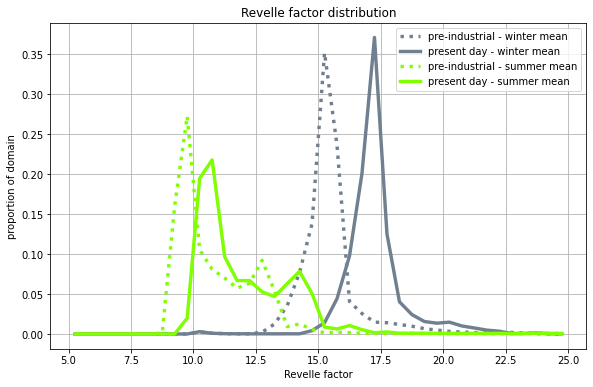

In [110]:
#concatenate winter summer
nbins = 40
#year_TA_DIC = np.concatenate((summer_TA_DIC_BR3,winter_TA_DIC_BR3),axis=0)
fact = 0.8
tdat = PI9_Revelle_w_surf

# print(hist)


fig = plt.figure(figsize=(12*fact, 7.5*fact))

ax6 = plt.subplot(1,1,1)
mask = (PI9_BetaD_winter_mean_surf>0) & ~np.isnan(PI9_BetaD_winter_mean_surf) & (csize_surf>0)
PI9_w, bins = np.histogram(PI9_BetaD_winter_mean_surf[mask], \
                                       bins=nbins, range = [5, 25], \
                                       weights=csize_surf[mask])
mask = (BR3_BetaD_winter_mean_surf>0) & ~np.isnan(BR3_BetaD_winter_mean_surf) & (csize_surf>0)
BR3_w, bins = np.histogram(BR3_BetaD_winter_mean_surf[mask], \
                                       bins=nbins, range = [5, 25], \
                                       weights=csize_surf[mask])

mask = (PI9_BetaD_summer_mean_surf>0) & ~np.isnan(PI9_BetaD_summer_mean_surf) & (csize_surf>0)
PI9_s, bins = np.histogram(PI9_BetaD_summer_mean_surf[mask], \
                                       bins=nbins, range = [5, 25], \
                                       weights=csize_surf[mask])

mask = (BR3_BetaD_summer_mean_surf>0) & ~np.isnan(BR3_BetaD_summer_mean_surf) & (csize_surf>0)
BR3_s, bins = np.histogram(BR3_BetaD_summer_mean_surf[mask], \
                                       bins=nbins, range = [5, 25], \
                                       weights=csize_surf[mask])

bin_cent = bins + (bins[1]-bins[0])/2
print(bin_cent)
tot_count = np.nansum(PI9_w)
ax6.plot(bin_cent[0:nbins],PI9_w/tot_count, color = 'slategray', linestyle = ':',\
         lw = 3.4,label = 'pre-industrial - winter mean')
tot_count = np.nansum(BR3_w)
ax6.plot(bin_cent[0:nbins],BR3_w/tot_count, color = 'slategray', linestyle = '-',\
         lw = 3.4,label = 'present day - winter mean')

# ##
tot_count = np.nansum(PI9_s)
ax6.plot(bin_cent[0:nbins],PI9_s/tot_count, color = 'chartreuse', linestyle = ':',\
         lw = 3.4,label = 'pre-industrial - summer mean')
tot_count = np.nansum(BR3_s)
ax6.plot(bin_cent[0:nbins],BR3_s/tot_count, color = 'chartreuse', linestyle = '-',\
         lw = 3.4,label = 'present day - summer mean')

ax6.legend(loc = 'best')
#ax6.set_xlim([-100,400])
ax6.set_title('Revelle factor distribution')
#ax6.axvline(x = 1, color = 'red', lw = 2)
ax6.set_xlabel('Revelle factor')
ax6.set_ylabel('proportion of domain')
ax6.grid()




In [103]:
PI9_w

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.54240085e+07, 1.79384088e+07,
       6.79382094e+06, 5.16200811e+06, 4.13516644e+06, 3.97017443e+07,
       2.22151428e+08, 6.19916435e+08, 1.36724232e+09, 2.44794836e+09,
       6.23793799e+09, 4.18450895e+09, 7.22018290e+08, 4.52052793e+08,
       2.62966635e+08, 2.49009706e+08, 2.10372458e+08, 1.72476873e+08,
       1.17210502e+08, 8.69139280e+07])

In [107]:
print(np.average(PI9_BetaD_winter_mean_surf[mask], weights=csize_surf[mask]))
print(np.average(PI9_BetaD_summer_mean_surf[mask], weights=csize_surf[mask]))

print(np.average(BR3_BetaD_winter_mean_surf[mask], weights=csize_surf[mask]))
print(np.average(BR3_BetaD_summer_mean_surf[mask], weights=csize_surf[mask]))



15.465589702242783
10.952919476994795
17.283817694928224
12.075164913156271


In [ ]:
889/(898*398*0.3)

In [ ]:
# print(np.size(PI8_Revelle_w_surf[mask]))
# print(np.max(PI8_Revelle_w_surf[mask]))
# print(tot_count)
# print(hist_year_omega_A)

0.44359305728989185


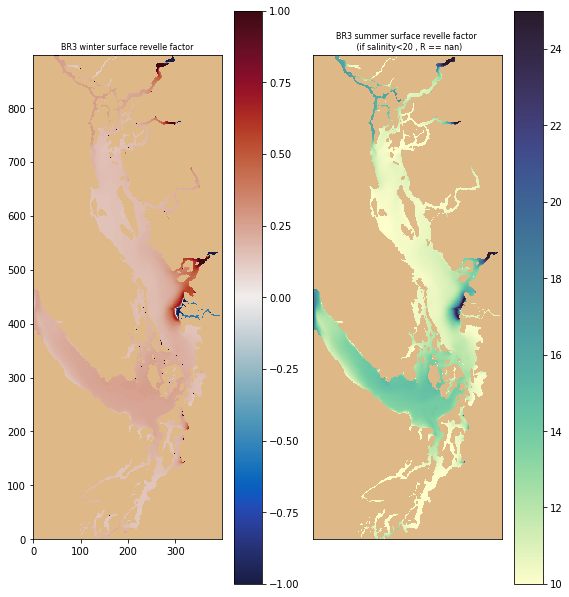

In [69]:

fact = 0.8
fig = plt.figure(figsize=(10*fact, 10.5*fact)) 
fs = 8
ax3 = plt.subplot2grid((1,2), (0,0), colspan=1,rowspan = 2)
tplt = diffvibe
print(tplt[860,270])
viz_tools.set_aspect(ax3)
mesh = ax3.pcolormesh(tplt, cmap=cm.balance, vmin = -1, vmax = 1)#, cmap=cm.balance, vmin=-120, vmax=120)
viz_tools.plot_land_mask(ax3, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
ax3.set_title('BR3 winter surface revelle factor', fontsize = fs)
# plt.xticks([])
# plt.yticks([])
cbar = plt.colorbar(mesh)


ax5 = plt.subplot2grid((1,2), (0,1), colspan=1,rowspan = 2)
tplt = BR3_Revelle_s_surf
viz_tools.set_aspect(ax5)
mesh = ax5.pcolormesh(tplt, cmap=cm.deep, vmin = 10, vmax = 25)
viz_tools.plot_land_mask(ax5, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
#ax5.set_title('Annual Air-Sea Flux \n (preindustrial run)', fontsize = fs)
ax5.set_title('BR3 summer surface revelle factor \n (if salinity<20 , R == nan)', fontsize = fs)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(mesh)
#cbar.ax.tick_params(labelsize=fs, rotation = 90)
#cbar.set_label('g C $m^{-2}$$yr^{-1}$', fontsize = fs)
#ax5.text(0.03, 0.03, 'b)', transform=ax5.transAxes, fontsize=16, fontweight='bold', va='bottom')


plt.tight_layout()
# plt.savefig('Fig3_ab.jpg', dpi = 600)

## summer and winter mean temps BR3 (commented out)

In [ ]:
import glob
# summer and winter mean 

#winter1 - december

start ='2015-12-01'
end ='2015-12-31'

start_run = arrow.get(start)
end_run = arrow.get(end)

arrow_array1 = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array1.append(r)
dayslen = len(arrow_array1)

BR_winter1 = np.zeros([dayslen,40,898,398])

for i in range(0,dayslen):

    tdate = arrow_array1[i][0]
    ymd = tdate.format('YYYYMMDD')

    if i%20 == 0:
        print(ymd)
    tstr = glob.glob('//data/tjarniko/results/BASERUN_EXP/PI8/ncs/SKOG*carp*'+ymd+'*.nc')
    tnc = tstr[0]
    tn = nc.Dataset(tnc)
    t_dic = tn['dissolved_inorganic_carbon'][0,:,:,:]
    BR_winter1[i,:,:,:] = t_dic

#winter 2 is january-february
start ='2015-01-01'
end ='2015-02-28'

start_run = arrow.get(start)
end_run = arrow.get(end)
arrow_array2 = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array2.append(r)
dayslen = len(arrow_array2)

BR_winter2 = np.zeros([dayslen,40,898,398])

for i in range(0,dayslen):

    tdate = arrow_array2[i][0]
    ymd = tdate.format('YYYYMMDD')

    if i%20 == 0:
        print(ymd)
    tstr = glob.glob('//data/tjarniko/results/BASERUN_EXP/PI8/ncs/SKOG*carp*'+ymd+'*.nc')
    tnc = tstr[0]
    tn = nc.Dataset(tnc)
    t_dic = tn['dissolved_inorganic_carbon'][0,:,:,:]
    BR_winter2[i,:,:,:] = t_dic


BR_winter = np.concatenate((BR_winter1,BR_winter2),axis=0)
print(np.shape(BR_winter))
BR_winter_mean = np.nanmean(BR_winter,axis=0)
pickle.dump(BR_winter_mean, open("./pkls/PI8_DIC_winter_mean.pkl", 'wb'))

start ='2015-06-01'
end ='2015-08-31'

start_run = arrow.get(start)
end_run = arrow.get(end)

arrow_array1 = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array1.append(r)
dayslen = len(arrow_array1)

BR_oma_summer1 = np.zeros([dayslen,40,898,398])

for i in range(0,dayslen):

    tdate = arrow_array1[i][0]
    ymd = tdate.format('YYYYMMDD')

    if i%10 == 0:
        print(ymd)
    tstr = glob.glob('//data/tjarniko/results/BASERUN_EXP/MAIN/BR_3rd_2015/ncs/SKOG*carp*'+ymd+'*.nc')
    tnc = tstr[0]
    tn = nc.Dataset(tnc)
    t_dic = tn['dissolved_inorganic_carbon'][0,:,:,:]
    BR_oma_summer1[i,:,:,:] = t_dic


print(np.shape(BR_oma_summer1))
BR_oma_summer_mean = np.nanmean(BR_oma_summer1,axis=0)
pickle.dump(BR_oma_summer_mean, open("./pkls/PI8_DIC_summer_mean.pkl", 'wb'))

In [ ]:
import glob
# summer and winter mean 

#winter1 - december

start ='2015-12-01'
end ='2015-12-31'

start_run = arrow.get(start)
end_run = arrow.get(end)

arrow_array1 = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array1.append(r)
dayslen = len(arrow_array1)

BR_winter1 = np.zeros([dayslen,40,898,398])

for i in range(0,dayslen):

    tdate = arrow_array1[i][0]
    ymd = tdate.format('YYYYMMDD')

    if i%20 == 0:
        print(ymd)
    tstr = glob.glob('//data/tjarniko/results/BASERUN_EXP/PI8/ncs/SKOG*carp*'+ymd+'*.nc')
    tnc = tstr[0]
    tn = nc.Dataset(tnc)
    t_TA = tn['dissolved_inorganic_carbon'][0,:,:,:]
    BR_winter1[i,:,:,:] = t_TA

#winter 2 is january-february
start ='2015-01-01'
end ='2015-02-28'

start_run = arrow.get(start)
end_run = arrow.get(end)
arrow_array2 = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array2.append(r)
dayslen = len(arrow_array2)

BR_winter2 = np.zeros([dayslen,40,898,398])

for i in range(0,dayslen):

    tdate = arrow_array2[i][0]
    ymd = tdate.format('YYYYMMDD')

    if i%20 == 0:
        print(ymd)
    tstr = glob.glob('//data/tjarniko/results/BASERUN_EXP/PI8/ncs/SKOG*carp*'+ymd+'*.nc')
    tnc = tstr[0]
    tn = nc.Dataset(tnc)
    t_TA = tn['total_alkalinity'][0,:,:,:]
    BR_winter2[i,:,:,:] = t_TA


BR_winter = np.concatenate((BR_winter1,BR_winter2),axis=0)
print(np.shape(BR_winter))
BR_winter_mean = np.nanmean(BR_winter,axis=0)
pickle.dump(BR_winter_mean, open("./pkls/PI8_TA_winter_mean.pkl", 'wb'))

start ='2015-06-01'
end ='2015-08-31'

start_run = arrow.get(start)
end_run = arrow.get(end)

arrow_array1 = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array1.append(r)
dayslen = len(arrow_array1)

BR_oma_summer1 = np.zeros([dayslen,40,898,398])

for i in range(0,dayslen):

    tdate = arrow_array1[i][0]
    ymd = tdate.format('YYYYMMDD')

    if i%10 == 0:
        print(ymd)
    tstr = glob.glob('//data/tjarniko/results/BASERUN_EXP/PI8/ncs/SKOG*carp*'+ymd+'*.nc')
    tnc = tstr[0]
    tn = nc.Dataset(tnc)
    t_TA = tn['total_alkalinity'][0,:,:,:]
    BR_oma_summer1[i,:,:,:] = t_TA


print(np.shape(BR_oma_summer1))
BR_oma_summer_mean = np.nanmean(BR_oma_summer1,axis=0)
pickle.dump(BR_oma_summer_mean, open("./pkls/PI8_TA_summer_mean.pkl", 'wb'))

In [ ]:
# #concatenate winter summer
# nbins = 50
# # year_TA_DIC = np.concatenate((summer_TA_DIC_BR3,winter_TA_DIC_BR3),axis=0)

# # print(hist)
# bin_cent = bins + (bins[1]-bins[0])/2

# fig = plt.figure(figsize=(12*fact, 9.5*fact))

# ax6 = plt.subplot(3,1,1)
# hist_year_omega_A, bins = np.histogram(year_omega_A[year_omega_A>0], \
#                                        bins=nbins, range = [0, 3], \
#                                        weights=csize2[year_omega_A>0])
# tot_count = np.sum(hist_year_omega_A)
# ax6.plot(bin_cent[0:nbins],hist_year_omega_A/tot_count, color = 'slategray',\
#          lw = 3.4,label = 'BR - winter mean')

# ax6.legend(loc = 'best')
# #ax6.set_xlim([-100,400])
# ax6.set_title('$TA-DIC$ distribution')
# ax6.axvline(x = 1, color = 'red', lw = 2)
# ax6.set_xlabel('$TA-DIC$')
# ax6.set_ylabel('proportion of domain')


